In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
import rpy2
import numpy as np

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

from rpy2.robjects.packages import importr, data


utils = importr('utils')
base = importr('base')
%load_ext rpy2.ipython

In [3]:
def to_rdf(df):
    with (robjects.default_converter + pandas2ri.converter).context():
        rdf = robjects.conversion.get_conversion().py2rpy(df)
    return rdf

def to_df(rdf):
    with (robjects.default_converter + pandas2ri.converter).context():
        df = robjects.conversion.get_conversion().rpy2py(rdf)

    return df



In [4]:
%%R
R.version.string

[1] "R version 4.2.2 Patched (2022-11-10 r83330)"


In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/dados1/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/dados1/usr/lib/R/site-library’ contains no packages
3: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/dados1/usr/lib/R/site-library’ contains no packages


## Instalar pacotes do R localmente (só para seu usuário)
Talvez é necessário usar
```
utils.install_packages('mirt')
```
e o equivalente de outros pacotes.


In [5]:
mirt = importr('mirt')

In [7]:
df = pd.read_csv('data/ch19.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,acertos,caderno,nota_inep
0,0,1,0,0,1,1,1,0,0,0,...,0,0,1,0,1,0,0,12,510,480.1
1,0,1,0,1,0,0,1,0,0,1,...,0,0,1,0,1,0,0,13,510,468.2
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,10,509,418.1
3,0,1,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,16,508,543.6
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,9,509,438.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31524,0,1,1,0,1,0,1,1,1,1,...,1,0,0,0,0,0,0,15,508,482.7
31525,1,1,0,0,0,1,1,0,1,1,...,1,1,0,0,0,1,0,22,510,587.2
31526,0,0,1,0,1,1,1,1,0,1,...,0,1,0,0,0,0,0,19,509,563.1
31527,0,1,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,13,508,499.5


In [9]:
resp = df.iloc[:,range(45)]
resp

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,1,0,1,0,0,1,0,0,1,...,1,0,0,0,0,1,0,1,0,0
2,1,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,1,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31524,0,1,1,0,1,0,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
31525,1,1,0,0,0,1,1,0,1,1,...,1,0,0,1,1,0,0,0,1,0
31526,0,0,1,0,1,1,1,1,0,1,...,1,0,0,0,1,0,0,0,0,0
31527,0,1,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
rdf = to_rdf(resp)

In [ ]:
model3pl = mirt.mirt(rdf,1,itemtype="3PL",method="QMCEM")

Iteration: 38, Log-Lik: -881204.659, Max-Change: 0.00055

In [57]:
mirt.extract_mirt(model3pl,'method')

QMCEM


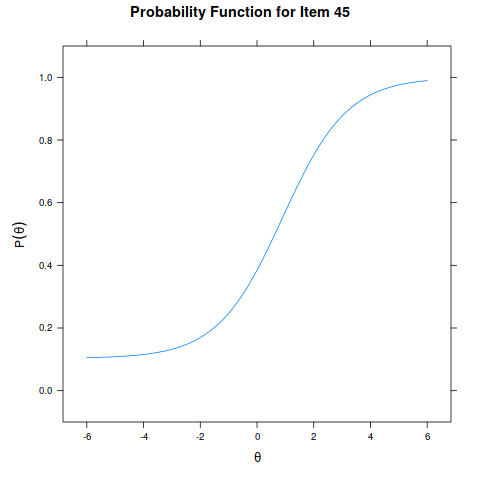

In [58]:
%%R -i model3pl
itemplot(model3pl,45)

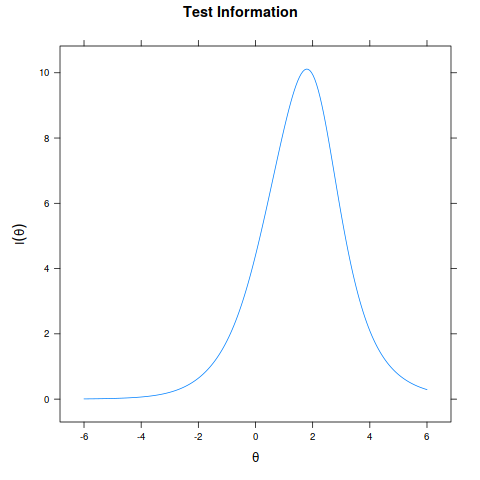

In [59]:
%%R
plot(model3pl,type="info", facet_items=TRUE)

In [68]:
thetas3plmap = mirt.fscores(model3pl,method="MAP",full_scores=True)
thetas3pleap = mirt.fscores(model3pl,method="EAP",full_scores=True)


  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03m 18s       |+                                                 | 2 % ~03m 17s       |++                                                | 3 % ~03m 14s       |++                                                | 4 % ~03m 12s       |+++                                               | 5 % ~03m 10s       |+++                                               | 6 % ~03m 08s       |++++                                              | 7 % ~03m 06s       |++++                                              | 8 % ~03m 04s       |+++++                                             | 9 % ~03m 02s       |+++++                                             | 10% ~02m 60s       |++++++                                            | 11% ~02m 58s       |++++++                                            | 12% ~02m 56s       |+++++++                                           | 13% ~02m 

In [70]:
df['theta3plmap'] = thetas3plmap
df['theta3pleap'] = thetas3pleap


In [72]:
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,acertos,caderno,nota_inep,theta,theta3pl,theta3plmap,theta3pleap
15330,1,0,0,0,0,0,1,0,0,0,...,1,0,0,9,509,388.2,-1.146290,-1.192094,-1.079253,-1.192094
2342,0,1,0,1,1,1,1,0,1,0,...,0,1,0,16,510,522.5,0.157478,0.248457,0.310817,0.248457
9704,0,1,0,1,1,1,1,0,0,1,...,0,1,0,28,509,622.3,1.452171,1.468567,1.494111,1.468567
26476,0,1,0,1,0,0,0,0,1,1,...,0,0,0,11,508,446.3,-0.586825,-0.541704,-0.396522,-0.541704
10976,1,0,1,1,0,0,0,1,0,1,...,0,1,0,14,509,500.1,-0.477528,-0.525624,-0.401138,-0.525624


<AxesSubplot:xlabel='nota_inep', ylabel='theta3pleap'>

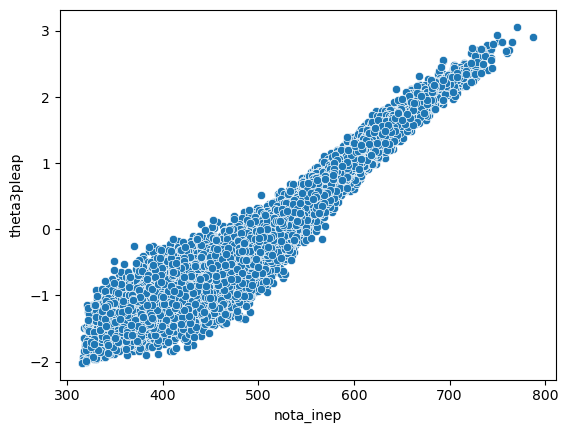

In [95]:
sns.scatterplot(df,y='theta3pleap',x='nota_inep')
#sns.scatterplot(df,x='acertos',y='theta3plmap')

In [100]:
print(mirt.summary(model3pl))

      F1     h2
0  0.661 0.4373
1  0.630 0.3964
2  0.679 0.4613
3  0.471 0.2220
4  0.683 0.4659
5  0.597 0.3567
6  0.366 0.1343
7  0.504 0.2545
8  0.607 0.3682
9  0.623 0.3887
10 0.429 0.1843
11 0.518 0.2685
12 0.664 0.4413
13 0.705 0.4967
14 0.471 0.2222
15 0.601 0.3616
16 0.301 0.0903
17 0.678 0.4600
18 0.422 0.1781
19 0.641 0.4103
20 0.530 0.2805
21 0.587 0.3444
22 0.538 0.2897
23 0.495 0.2450
24 0.352 0.1241
25 0.402 0.1618
26 0.473 0.2239
27 0.602 0.3629
28 0.727 0.5279
29 0.475 0.2258
30 0.624 0.3891
31 0.685 0.4698
32 0.575 0.3309
33 0.388 0.1509
34 0.518 0.2688
35 0.662 0.4382
36 0.452 0.2045
37 0.476 0.2263
38 0.344 0.1185
39 0.648 0.4199
40 0.778 0.6060
41 0.489 0.2396
42 0.461 0.2123
43 0.625 0.3905
44 0.456 0.2081

SS loadings:  14.058 
Proportion Var:  0.312 

Factor correlations: 

   F1
F1  1
$rotF
          F1
0  0.6612605
1  0.6295902
2  0.6791687
3  0.4712086
4  0.6825750
5  0.5972161
6  0.3664017
7  0.5044662
8  0.6067999
9  0.6234201
10 0.4292441
11 0.5181736
12 0.6

<AxesSubplot:xlabel='acertos', ylabel='Count'>

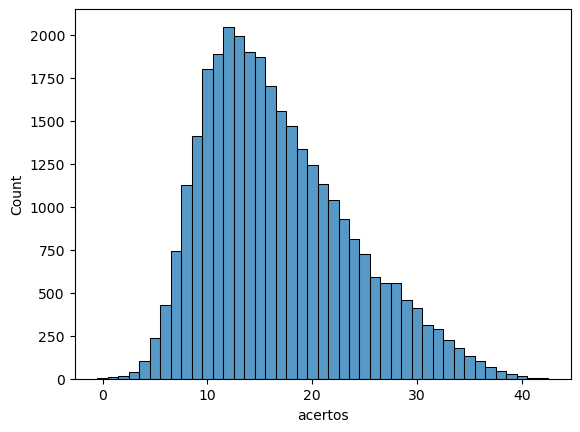

In [89]:
sns.histplot(df,x='acertos',discrete=True)

In [99]:
itens = pd.read_csv('data/ITENS_PROVA_2019.csv',encoding='latin1',sep=';')

In [101]:
itens[:2]

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
0,1,LC,17910,D,6,0,NaN,2.64336,0.3311,0.17368,Azul,551,1.0,0
1,1,LC,17910,D,6,0,NaN,2.64336,0.3311,0.17368,Laranja,565,1.0,0


In [103]:
itens.query("IN_ITEM_ABAN == 1 & SG_AREA == 'CH'")

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
582,48,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,507,NaN,0
770,66,CH,76955,B,27,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branca,509,NaN,0
813,69,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branca,509,NaN,0
841,72,CH,76955,B,27,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,510,NaN,0
879,75,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,510,NaN,0
903,78,CH,76955,B,27,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarela,508,NaN,0
904,78,CH,76955,B,27,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Laranja,520,NaN,0
905,78,CH,76955,B,27,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Verde,524,NaN,1
943,81,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarela,508,NaN,0
944,81,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Laranja,520,NaN,0


In [99]:
itens.sort_values("IN_ITEM_ABAN",ascending=False)[:40]

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
879,75,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,510,NaN,0
1548,141,MT,23065,C,14,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Verde,526,NaN,1
1430,129,CN,83609,E,18,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,506,NaN,0
1429,129,CN,42605,B,6,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,545,NaN,0
1546,141,MT,23065,C,14,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Cinza,518,NaN,0
1126,99,CN,42605,B,6,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,546,NaN,0
841,72,CH,76955,B,27,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,510,NaN,0
1547,141,MT,23065,C,14,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Laranja,522,NaN,0
1877,174,MT,28698,C,3,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Cinza,556,NaN,0
416,33,LC,118260,E,15,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,511,NaN,0
